# Visualisation des données

In [18]:
### Importation de librairies ###
import pandas as pd 
import calplot
import plotly.express as px
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import os, warnings
warnings.simplefilter("ignore")

#Fonctions personnels pour la visualisation des données
import eda

In [19]:
#Chargement des données
df = pd.read_csv("dataset_final.csv") #comporte 1704 jours
df["date"] = pd.to_datetime(df["date"])
df.set_index('date', inplace = True)
#division des données
df_train = df[df.index < '2016-04-25']
df_val = df[df.index >= '2016-04-25' ]

## Visualisation de notre série chronologique

In [21]:
ts_columns  = ['sales', 'prix', 'snap_WI', 'temp']
eda.plot_list_ts(df_train, ts_columns)

## Moyenne par mois et par jour


In [22]:
sales_per_month = df_train.groupby('month')['sales'].mean()
eda.plot_ts(sales_per_month, "Moyenne des ventes par mois", "Mois", "Ventes")
sales_per_day = df_train.groupby('wday')['sales'].mean()
eda.plot_ts(sales_per_day, "Moyenne des ventes par jour", "Jour", "Ventes")

In [23]:
#rajout d'une variable: normalisation des ventes par mois
monthly_mean = df_train.groupby(df_train.index.month)['sales'].transform('mean')
monthly_std = df_train.groupby(df_train.index.month)['sales'].transform('std')

monthly_mean_ts = df_train.groupby(df_train.index.month)['sales'].transform('mean')
monthly_std_ts = df_train.groupby(df_train.index.month)['sales'].transform('std')

df_train['normalized_sales'] = (df_train['sales'] - monthly_mean_ts)/monthly_std_ts

## Les données météo

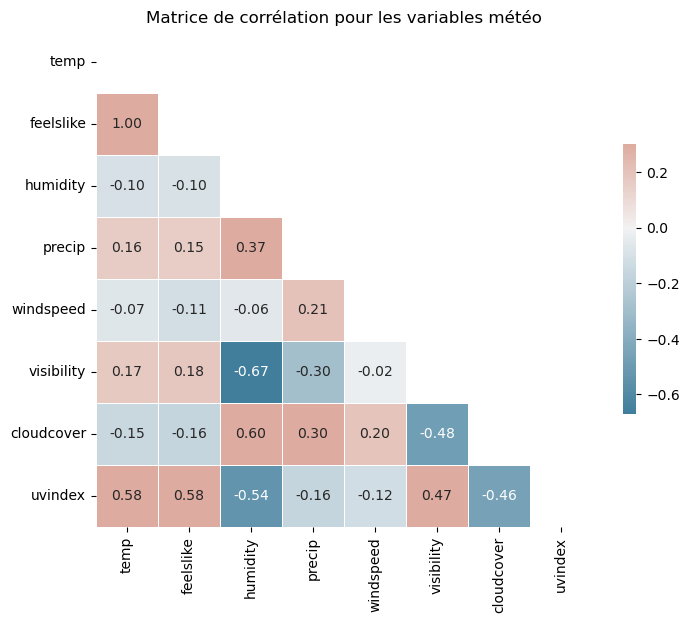

In [24]:
names_meteo = ['temp', 'feelslike', 'humidity', 'precip', 'preciptype',
       'windspeed', 'visibility', 'cloudcover', 'uvindex']
df_meteo = df[names_meteo]
eda.plot_correlation(df_meteo, 'Matrice de corrélation pour les variables météo')

In [25]:
def apply_threshold_temp(x):
    """
    treshold par z-score pour la variable meteo temp
    """
    if x <= -2 or x >= 2.5:
        return 1
    else:
        return 0
    
def apply_treshold_precip(x):
    """
    treshold par z-score pour la variable meteo precip
    """
    if x >= 1.96: 
        return 1
    else: 
        return 0

In [26]:
#suppression des variables météo non utilisées
df.drop(['feelslike', 'humidity', 'preciptype',
       'windspeed', 'visibility', 'cloudcover', 'uvindex',], axis=1, inplace=True)

#Normalisation de nos variables météo
df['temp_scaled'] = (df['temp'] - df['temp'].mean())/df['temp'].std()
df['precip_scaled'] = (df['precip'] - df['precip'].mean())/df['precip'].std()

#Création de nos nouvelles variables "extrêmes"
df['extreme_temp'] = df['temp_scaled'].apply(apply_threshold_temp)
df['extreme_precip'] = df['precip_scaled'].apply(apply_threshold_temp)


#On divise de nouveau le dataset en prenant en compte nos changements
df_train = df[df.index < '2016-04-25']
df_val = df[df.index >= '2016-04-25' ]

## Les données évènements

In [27]:
df = pd.get_dummies(df, columns=['event_type_1']) #one hot encoding des évènements par type
df = df.drop(['event_type_1_no_event'], axis=1) # variable inutile
#On divise de nouveau le dataset en prenant en compte nos changements
df_train = df[df.index < '2016-04-25']
df_val = df[df.index >= '2016-04-25' ]

In [29]:
sales_n_events = ['sales', 'event_name_1']
eda.plot_list_ts(df_train, sales_n_events)

In [30]:
#suppression des variables "event":
df = df.drop(['event_type_1_Cultural', 'event_type_1_National',
       'event_type_1_Religious', 'event_type_1_Sporting'], axis=1)
df_train = df[df.index < '2016-04-25']
df_val = df[df.index >= '2016-04-25' ]

## Corrélation entre les variables

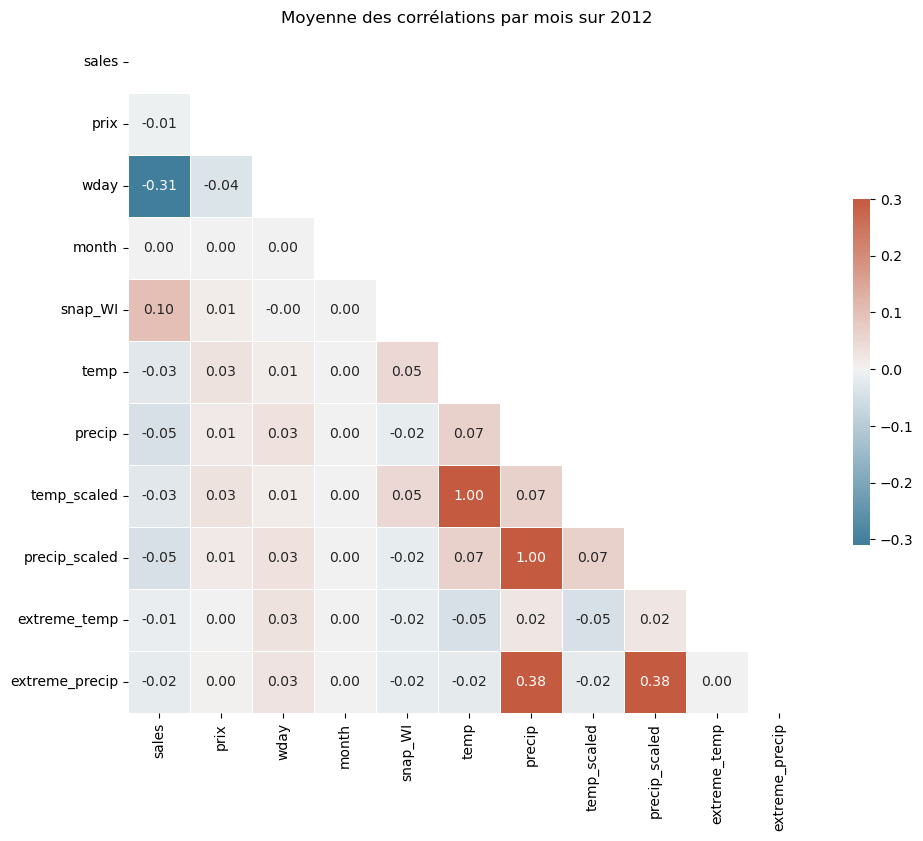

In [32]:
#plot_mean_corr(df_train)
eda.plot_mean_corr(df_train[df_train.index.year == 2012])

In [33]:
# Code enlever par soucis de clarté
# Il affiche la matrice de corrélation pour chaque mois de 2012

# for m in range(1,13): 
#     df_train_2012_month = df_train_2012[df_train_2012.index.month == m ]
#     title = 'Mois: '+str(m)
#     eda.plot_correlation(df_train_2012_month, title)

## Bilan de l'EDA

Par cette analyse des variables explicatives on se rend compte que les variables suivantes sont les plus importantes.
- 'prix' 
- 'wday'
- 'month' 
- 'snap_WI'

Dans une moindre mesure, on pourra essayer d'utiliser nos variables de météo "extrême" dans nos modèles. 